# **Importamos las Dependencias**

In [31]:
# Para graficar
import seaborn as sns
import matplotlib.pyplot as plt

# Para el manejo de datos
import pandas as pd
import numpy as np

# Para la reducción de las dimensiones y elección de características 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # Para clasificación en el KBest



### Para la construcción de los modelos ###

# Preparación de los datos
from sklearn.model_selection import train_test_split # Para divir los conjuntos de datos
from sklearn.model_selection import RandomizedSearchCV # Para la busqueda aleatoria de hiperparámetros
from sklearn.model_selection import GridSearchCV # Para la busqueda de hiperparámetro de manera exaustiva
from sklearn.preprocessing import MinMaxScaler # Para escalar nuestros datos
from sklearn.preprocessing import StandardScaler # Normaliza nuestros datos

# Modelos
from sklearn.neural_network import MLPRegressor # Perceptrón multicapa para regresión
from sklearn.neural_network import MLPClassifier # Perceptrón multicapa para clasificación
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Evaluación de los modelos
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # Para evaluar la regresión
from sklearn.metrics import roc_auc_score # Evalua el rendimiento de modelos de clasificación binaria.
from sklearn.metrics import roc_curve # Crea una curva ROC (Receiver Operating Characteristic)
from sklearn.metrics import accuracy_score, confusion_matrix


# Para realizar nuestras pruebas de hipótesis
from scipy import stats

# Herramienta para hacer programación funcional
from functools import reduce

# **Carga de datos**

In [32]:
df = pd.read_excel('Datos de clientes (DataSet).xlsx')

# **Análisis Exploratorio y Preprocesamiento Avanzado**

### **Gráficas**

In [33]:
# Veamos la dimensión de de nuestro DataFrame
df.shape

(30000, 24)

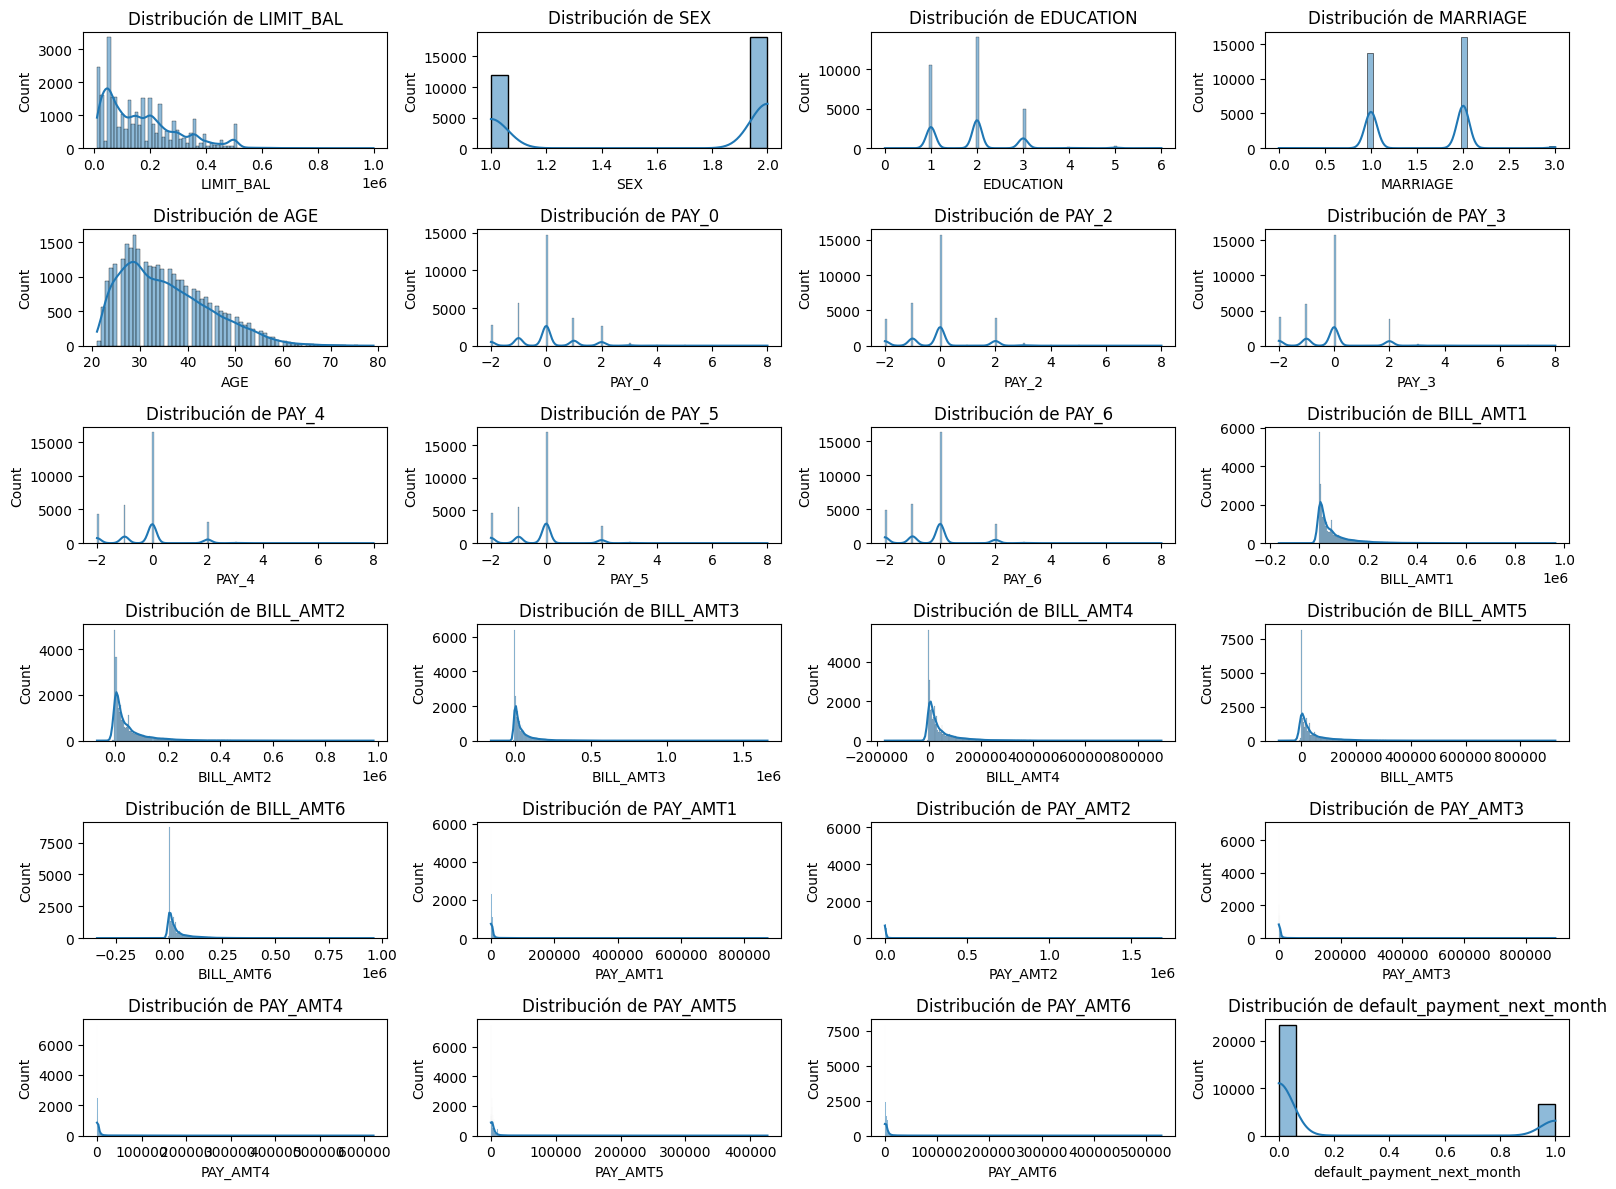

In [34]:
# Graficamos las distribuciones de nuestros datos

# Veamos sus distribuciones de probabilidad


# Creamos la figura y los subplots
fig, axes = plt.subplots(nrows = 6, ncols = 4, figsize = (16, 12)) # 6 filas X 4 Columnas = 24 figuras


# Iteramos sobre las columnas y sus ínidices
for i, columna in enumerate(df.columns):

    """
    Aquí, como tenemos 6 filas y 4 columnas, queremos que cada gráfica esté en una fila
    y una columna particular, entonces calculamos que se acomoden en 'paquetes'    
    """
    fila = i//4 # Calcula la fila del subplot
    columna_subplot = i%4 # Calcula la columna del subplot

    """
    -> ax = axes[...] especifica el subplot donde se debe de graficar
    -> kde=True muestra la estimación de densidad
    """

    sns.histplot(df[columna], kde = True, ax = axes[fila, columna_subplot]) 
    axes[fila, columna_subplot].set_title(f'Distribución de {columna}')


# Ajusta el layout para evitar superposición de elementos
plt.tight_layout()

# Muestra el gráfico
plt.show()

### **Tratamiento de datos atípicos**

Definimos los dos métodos más usados para la detección de datos atípicos

In [35]:
def cerca_percentil(Data, percentil_inf, percentil_sup, opcion = 0):

    # Establecemos los percentiles
    percentil_1 = np.percentile(Data, percentil_inf)
    percentil_2 = np.percentile(Data, percentil_sup)

    # Filtramos los datos que noe esten en esos límites
    Data_filtrada = Data[ (Data >= percentil_1) & (Data <= percentil_2) ]

    if opcion == 1:
        # Mostramos resultados
        print(f'\nPara la columna {Data.name} tenemos los siguientes resultados: \n')
        print(f'Percentil 1: {percentil_1:.2f}')
        print(f'Percentil 2: {percentil_2:.2f}')
        print(f'Cantidad de datos antes: {len(df)}')
        print(f'Cantidad de datos después: {len(Data_filtrada)}')
        print(f'Porcentaje eliminado: {(len(Data) - len(Data_filtrada))/len(Data) * 100}%')

    return Data_filtrada



def iqr_outliers(Data, factor = 1.5, opcion = 0):
    
    # Calculamos los cuartiles Q1 (25%) y Q3 (75%)
    Q1 = np.percentile(Data, 25)
    Q3 = np.percentile(Data, 75)
    
    # Calculamos el IQR
    IQR = Q3 - Q1
    
    # Establecemos los límites inferior y superior para los outliers

    ##limite_inferior = Q1 - factor * IQR
    ##limite_superior = Q3 + factor * IQR

    limite_inferior = round(Q1 - factor * IQR)
    limite_superior = round(Q3 + factor * IQR)
    
    # Filtramos los datos que están dentro de los límites
    Data_filtrada = Data[(Data >= limite_inferior) & (Data <= limite_superior)]
    

    if opcion == 1:
        # Mostramos los resultados
        print(f'\nPara la columna {Data.name} tenemos los siguientes resultados: \n')
        print(f'Q1: {Q1:.2f}')
        print(f'Q3: {Q3:.2f}')
        print(f'IQR: {IQR:.2f}')
        print(f'Límite Inferior: {limite_inferior:.2f}')
        print(f'Límite Superior: {limite_superior:.2f}')
        print(f'Cantidad de datos antes: {len(Data)}')
        print(f'Cantidad de datos después: {len(Data_filtrada)}')
        print(f'Porcentaje eliminado: {(len(Data) - len(Data_filtrada))/len(Data) * 100:.2f}%')
    
    return Data_filtrada

In [36]:
# Probemos cual es mejor para la edad

a = cerca_percentil(df['AGE'], 3, 97, 1)
b = iqr_outliers(df['AGE'], 1.6, 1)


Para la columna AGE tenemos los siguientes resultados: 

Percentil 1: 23.00
Percentil 2: 55.00
Cantidad de datos antes: 30000
Cantidad de datos después: 28529
Porcentaje eliminado: 4.903333333333333%

Para la columna AGE tenemos los siguientes resultados: 

Q1: 28.00
Q3: 41.00
IQR: 13.00
Límite Inferior: 7.00
Límite Superior: 62.00
Cantidad de datos antes: 30000
Cantidad de datos después: 29828
Porcentaje eliminado: 0.57%


Text(0.5, 1.0, 'Cercado')

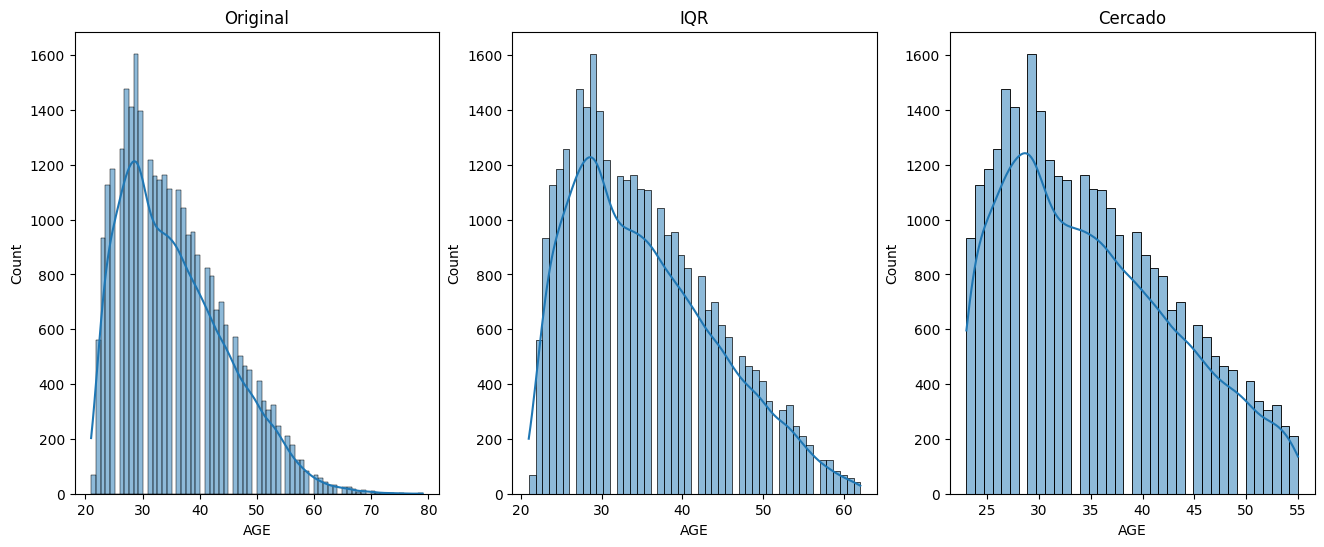

In [37]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 6)) 

# Gráfica originaL
sns.histplot(df['AGE'], kde=True, ax = axes[0])
axes[0].set_title('Original')

# Gráfica del IQR
sns.histplot(b, kde=True, ax = axes[1])
axes[1].set_title('IQR')

sns.histplot(a, kde=True, ax = axes[2])
axes[2].set_title('Cercado')


Debido al contexto bancario, no podemos despreciar a la población joven y la que va empezando su tercera edad, entonces vamos a quedarnos con el IQR, ya que la cantidad de personas que son mayores a 62 años son menos del $1$%

<br>

Para que el DataFrame nos quede del mismo tamaño, vamos a tomar una columna 'característica', la cual nos va a ayudar e eliminar el resto de índices de las otras columnas. Y vamos a tomar la columna **AGE** 

In [38]:
# Hacemos una copia del DataFrame original
df2 = df.copy()

# Eliminamos los datos correspondientes
df2 = df.loc[df['AGE'].isin(b)]

### **Escalamos los datos**

In [39]:
# Hacemos una instancia del StandardScaler
scaler = StandardScaler()

# Ajustamos el escalador con nuestros datos
scaler.fit_transform(df2)

# Transformamos los datos
scaled_data = scaler.transform(df2)

# Lo hacemos en todo el dataframe
scaled_df = pd.DataFrame(scaled_data, columns=df2.columns)

### **Reducción de dimensionalidad**

##### **PCA**

Varianza explicada por cada componente: [0.27276251 0.17498933 0.06471513 0.061706   0.04330669 0.04061623
 0.03822361 0.03778426 0.0369493  0.03625069 0.03257023 0.03048833
 0.02616232 0.0237303 ]
Varianza total explicada: 0.9202549322366291


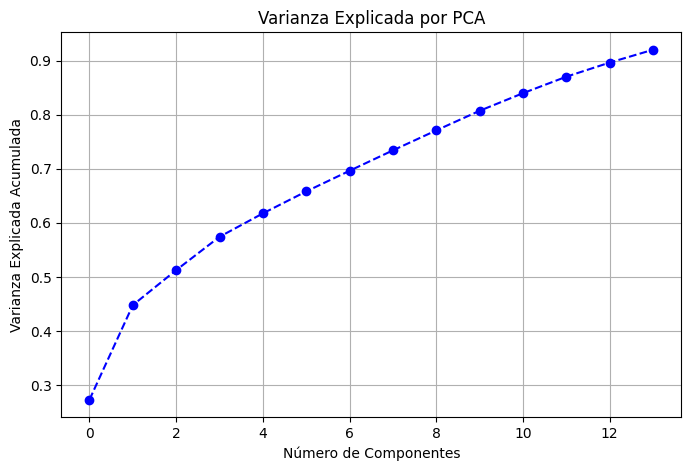

In [40]:
# Instanciamos el PCA
pca = PCA(n_components=14)

# Ajustamos el PCA  nuestros datos
pca.fit(scaled_df)

AnaPelada = pca.transform(scaled_df)

# Evaluamos la varianza explicada
explained_variance = pca.explained_variance_ratio_

# Mostramos los resultados
print("Varianza explicada por cada componente:", explained_variance)
print("Varianza total explicada:", np.sum(explained_variance))

# Graficamos la varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid(True)
plt.show()

In [41]:
# Crear DataFrame con las relaciones entre componentes y variables originales
componentes_df = pd.DataFrame(
        pca.components_, 
        columns=scaled_df.columns, 
        index=[f'PC{i+1}' for i in range(pca.n_components_)]
    )

# Mostrar qué variables influyen más en cada componente
print("\nComponentes principales y su relación con las variables originales:")
print(componentes_df)

# Variable más influyente en cada componente
print("\nVariable más influyente en cada componente:")
print(componentes_df.abs().idxmax(axis=1))




Componentes principales y su relación con las variables originales:
      LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2  \
PC1    0.064835 -0.020931   0.019692 -0.005261  0.011185  0.165502  0.198280   
PC2   -0.311820 -0.031974   0.088953  0.039032 -0.061184  0.295932  0.327117   
PC3   -0.013267 -0.021926   0.309489 -0.451666  0.458891  0.019797 -0.020444   
PC4    0.076991 -0.077728   0.234466 -0.448025  0.467797  0.021164  0.047853   
PC5   -0.197135  0.740590   0.447277 -0.024961 -0.139767 -0.111403 -0.052985   
PC6    0.271025  0.626580  -0.402700 -0.232605 -0.001568  0.130966  0.060570   
PC7   -0.258674  0.011906   0.420588  0.186059 -0.143273  0.220312  0.048378   
PC8   -0.025284 -0.059481   0.288269  0.103974 -0.044659  0.015908  0.077290   
PC9   -0.020681 -0.050867   0.072414  0.013348  0.004574 -0.038809  0.012891   
PC10  -0.029819 -0.015013   0.158217  0.060441 -0.048575  0.035998  0.029506   
PC11   0.015758  0.012926   0.074331  0.035082  0.0

Con esto, vemos que con tan solo 14 variables de las 24 que hay podemos explicar más del $90$% de la varianza, así que si queremos construír algún modelo, podemos usar esas 14 variables y no las 24 totales, ya que de esas 14, tenemos casi toda la información.

<br>

Como algo interesante, notamos que las variables que mas aportan información al modelo son 'BILL_AMT4' y 'PAY_3', lo cual es curioso, pues 'BILL_AMT4' es el monto por pagar en junio del 2005; mientras que 'PAY_3' es el estatus de pago julio del 2005, lo cual indica aparentemente que lo más importante es la promesa de pago y el respectivo pago en esas fechas. 
Pensamos que es algo por lo menos interesante (aunque no sabemos si es relevante), ya que está justo a la mitad de todos los pagos (como si el modelo predijera que si pagaste/no pagaste la primera mitad es información relevante para ver como vas a pagar)

##### **T-SNE**

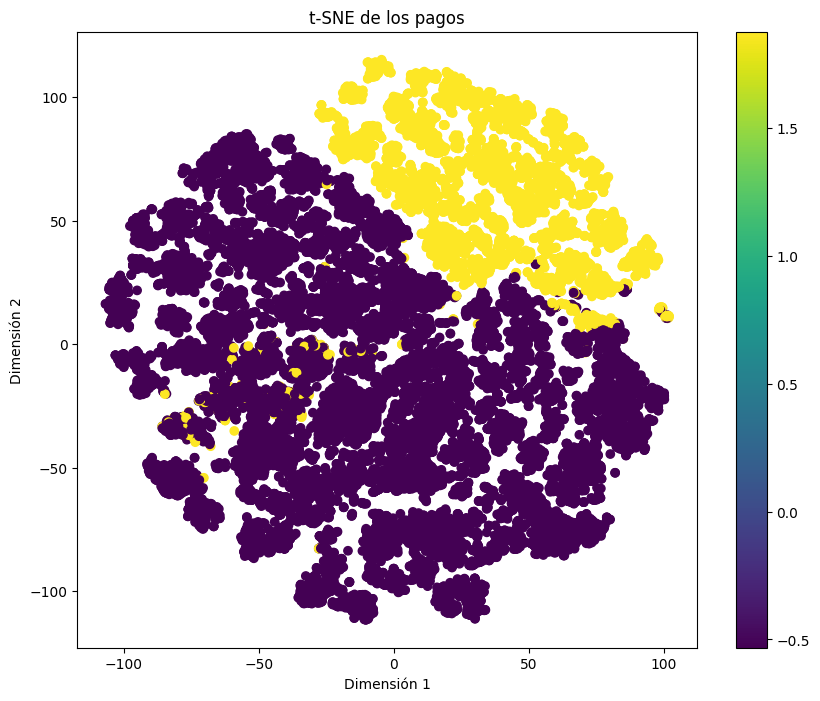

In [42]:
# Instanciamos al modelo
tsne = TSNE(n_components=2, random_state=42)

# Transformamos los datos del DataFrame
X_tsne = tsne.fit_transform(scaled_df)


# Creamos el marco para la gráfica
plt.figure(figsize=(10, 8))

# Graficamos
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=scaled_df['default_payment_next_month'], cmap="viridis")


plt.colorbar()
plt.title("t-SNE de los pagos")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

Esta gráfica, es un clúster en dónde agrupamos a las personas que pagan y que no pagan, y se basa en todas las características del DataSet para poder hacer la agrupación  

# **Modelado**

Vamos a contruír un modelo para intentar predecir el monto otorgado de prestamo bancario a un prospecto.

### **Decision Tree**

##### **Partición de los datos**

In [98]:
# Declaramos las variables
X = scaled_df[['LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
y = scaled_df['default_payment_next_month'].astype(int)

# Hacemos la partición
X_train, X_valid, y_train, y_valid = train_test_split( X, y, test_size = 0.3 )

In [100]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29823    0
29824    0
29825    1
29826    1
29827    1
Name: default_payment_next_month, Length: 29828, dtype: int64

##### **Creamos el modelo**

In [101]:
# Instanciamos el modelo
modelo = DecisionTreeClassifier()

In [102]:
modelo.fit(X_train, y_train)

DecisionTreeClassifier()

[Text(0.751295436613779, 0.9895833333333334, 'x[4] <= 1.35\ngini = 0.344\nsamples = 20879\nvalue = [16269, 4610]'),
 Text(0.5885975790446792, 0.96875, 'x[5] <= 1.365\ngini = 0.276\nsamples = 18685\nvalue = [15594, 3091]'),
 Text(0.669946507829229, 0.9791666666666667, 'True  '),
 Text(0.3777745258699623, 0.9479166666666666, 'x[14] <= -0.26\ngini = 0.245\nsamples = 17084\nvalue = [14647, 2437]'),
 Text(0.1421070874320738, 0.9270833333333334, 'x[10] <= -0.69\ngini = 0.334\nsamples = 4724\nvalue = [3723, 1001]'),
 Text(0.08821069812822521, 0.90625, 'x[15] <= -0.183\ngini = 0.391\nsamples = 1844\nvalue = [1353, 491]'),
 Text(0.06969748352061779, 0.8854166666666666, 'x[3] <= 0.133\ngini = 0.402\nsamples = 1648\nvalue = [1188, 460]'),
 Text(0.049885848765515634, 0.8645833333333334, 'x[13] <= -0.032\ngini = 0.369\nsamples = 939\nvalue = [710, 229]'),
 Text(0.043501683124138234, 0.84375, 'x[13] <= -0.048\ngini = 0.376\nsamples = 908\nvalue = [680, 228]'),
 Text(0.03192116653301174, 0.8229166666

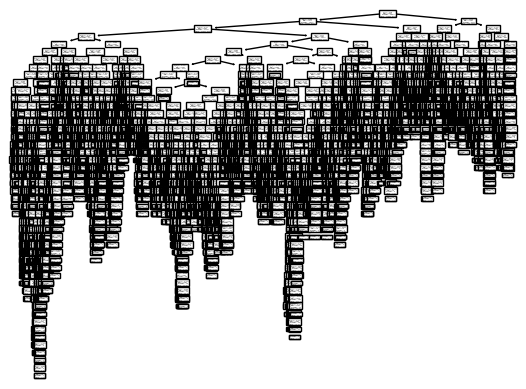

In [103]:
# Vemos el árbol de entrenamiento
plot_tree(modelo)

##### **Generalización del modelo**

In [104]:
# Medición de precisión
accuracy_score(y_train, modelo.predict(X_train)), accuracy_score(y_valid, modelo.predict(X_valid))

(0.9989942047032904, 0.7255559280366521)

In [105]:
# Aquí, hacemos las matrices de confusión
confusion_matrix(y_train, modelo.predict(X_train)), confusion_matrix(y_valid, modelo.predict(X_valid))

(array([[16267,     2],
        [   19,  4591]]),
 array([[5661, 1307],
        [1149,  832]]))

La matríz de cofunsión de los datos de validación es malísima, lo cual aunque tenga relativamente buen score en precisión general, es muy mala clasificando ciertos elementos de nuestro DataSet. Por lo tanto, es mala generalizando este conocimiento.


Podemos intentar cambiar parámetros mejorar su desempeño.

### **Redes Neuronales**

##### **Poder predictivo**

In [ ]:
# Vamos a usar los Select K-Best para elegir nuestras características

# Inspirados de los resultados del PCA, elegimos 14 características
k_mejores = SelectKBest(score_func=f_classif, k = 14) # -> Instanciamos el modelo

# Declaramos las variables
y = df2['default_payment_next_month']
X = k_mejores.fit_transform(scaled_df.iloc[:, :23], y)

# Vemos las características que eligió
best = [v for v,s in zip(k_mejores.feature_names_in_, k_mejores.get_support()) if s]

# Convertimos a X en un DataFrame
X_df = pd.DataFrame(scaled_df, columns = best)


# Esta línea de código también nos sirve para obtener las carcterísticas
# scaled_df.iloc[:, :23].columns[k_mejores.get_support()]

##### **Aprendizaje**

In [49]:
# Instanciamos el modelo
ann = MLPClassifier()

##### **Hiper-parametrización**

In [51]:
# Creamos un diccionario de los posibles hiper-parámetros

hp = {

    # Definimos una lista de tuplas que representan las diferentes combinaciones posibles de tamaños de capas ocultas para la red neuronal (dos capas)
    'hidden_layer_sizes': [(a,b) for a in range(1,12) for b in range(1,12)],

    # Definimos una lista de funciones de activación que se probarán
    'activation': ['relu', 'tanh', 'logistic', 'identity'],

    # Se probarán tres diferentes algoritmos de optimización para entrenar la red neuronal
    'solver': ['lbfgs', 'sgd', 'adam'],

    # Definimos una lista de estrategias de actualización de la tasa de aprendizaje
    'learning_rate': ['constant', 'invscaling', 'adaptive'],

    # Definimos una lista con un único valor, que representa el número máximo de iteraciones que se permitirán durante el entrenamiento del modelo
    'max_iter': [1000]

}


In [52]:
# Vamos a determinar el número total de posibles combinaciones de hiperparámetros que se pueden generar a partir de las opciones dadas

"""
-> reduce: Esta función toma dos argumentos. Una función y un iterable

-> lambda x,y:x*y: Esta es una función anónima (lambda) que toma dos argumentos, x e y, y devuelve su producto

-> map(len, hp.values()): Aplica la función "len" a cada elemento de "hp", además el resultado de esto es un iterable (como por ejemplo, una lista)

En pocas palabras, en la función "reduce" la función es la lambda que definimos, y el iterable es el resultado del "map"
y nos devuelve el número total de combinaciones de hiperparámetros a partir de un diccionario
"""

reduce(lambda x, y : x*y, map(len, hp.values()))

4356

In [81]:
# Hacemos la instancia de la busqueda aleatoria de hiperparámetros

grid = RandomizedSearchCV(

    ann, # Nuestro modelo

    param_distributions = hp, # Diccionario que  contiene las distribuciones de probabilidad para los hiperparámetros que se quieren probar

    n_iter = 50, # Número de iteraciones que se van a hacer para la busqueda

    scoring = 'roc_auc', # Métrica de evaluación que se utilizará para comparar los diferentes modelos

    n_jobs = -1, # Se van a usar todos los núcleos disponibles del procesador para hacer la busqueda en paralelo

    verbose = True, # Habilita la salida de mensajes de progreso durante la ejecución de la búsqueda

    cv = 10 # Número de folds

)

##### **Partición de los datos**

In [76]:
# Para poder replicar los resultados, establecemos una semilla aleatoria
rs = np.random.RandomState(20240905)

# Hacemos la partición
X_train, X_valid, y_train, y_valid = train_test_split( X_df, 
                                 y, 
                                 train_size = 0.7,
                                 random_state = rs
                                 )

#### **Busqueda de los hiperparámetros**

In [82]:
# Hacemos la busqueda


# La sintaxis es las siguiente:

# grid.fit(carácterísticas, variable_objetivo)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10,
                   estimator=MLPClassifier(hidden_layer_sizes=(6, 11),
                                           learning_rate='adaptive',
                                           max_iter=1000, solver='lbfgs'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic', 'identity'],
                                        'hidden_layer_sizes': [(1, 1), (1, 2),
                                                               (1, 3), (1, 4),
                                                               (1, 5), (1, 6),
                                                               (1, 7), (1, 8),
                                                               (1, 9), (1, 10),
                                                               (1, 11), (2, 1),
                                                               (2, 2), (2, 3),
                                                               (2, 4), (2, 5),
                                                               (2, 6), (2, 7),
                                                               (2, 8), (2, 9),
                                                               (2, 10), (2, 11),
                                                               (3, 1), (3, 2),
                                                               (3, 3), (3, 4),
                                                               (3, 5), (3, 6),
                                                               (3, 7), (3, 8), ...],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='roc_auc', verbose=True)

In [83]:
# Guardamos el resultado de la selección de los hiper-parámetros
ann = grid.best_estimator_
ann

MLPClassifier(activation='tanh', hidden_layer_sizes=(9, 9),
              learning_rate='invscaling', max_iter=1000)

In [84]:
# Vemos como quedó la red al final
grid.best_score_,grid.best_params_

(np.float64(0.7707985034083261),
 {'solver': 'adam',
  'max_iter': 1000,
  'learning_rate': 'invscaling',
  'hidden_layer_sizes': (9, 9),
  'activation': 'tanh'})

Obtenemos un $77.07$% de precisión, lo cual creo que podría tal vez podría mejorar con mayor computo, aunque creo que tal vez debería de replantear de nuevo el modelo, pues este resultado fue aumentando el número de folds de 5 a 10, pero con un coste del doble de tiempo de procesado, y la mejora que obtuve no fue ni del $1$%. 

Originalmente teníamos esto: 

<br>

```
(np.float64(0.7693194883184233),
 {'solver': 'lbfgs',
  'max_iter': 1000,
  'learning_rate': 'adaptive',
  'hidden_layer_sizes': (6, 11),
  'activation': 'relu'})
```

##### **Estimación de parámetros $\vec{\theta}$**

In [85]:
ann.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(9, 9),
              learning_rate='invscaling', max_iter=1000)

In [90]:
# Creamos un diccionario, en dónde vámos a calcular el área bajo la curva ROC (AUC) para nuestro modelo 
# de clasificación binario en dos conjuntos de datos: 
# uno de entrenamiento (train) y otro de validación (valid)



# Evaluación del modelo con AUC-ROC
resultados = {
    'train': roc_auc_score(y_true=y_train, y_score=ann.predict_proba(X_train)[:, 1]),
    'valid': roc_auc_score(y_true=y_valid, y_score=ann.predict_proba(X_valid)[:, 1])
}

print(resultados)

{'train': np.float64(0.7804065737567005), 'valid': np.float64(0.7724321262404863)}


Cómo las métricas de 'train' y 'valid' no nos muy distintas, es un buen indicador del modelo

### **Conclusiones**

El modelo que logramos construír, no es tan robusto como me gustaría, pero es muchísmo mejor que el que construímos primero.

Así que con esto, podemos tener un modelo lo suficienteme robusto como para predecir si un cliente va a pagar el siguiente mes